#### Skip-Gram/CBOW: Try learn embeddings of words

In [63]:
import torch
import random
import math
from typing import Union

In [64]:
corpus = [
    "the quick brown fox jumps over the lazy dog",
    "we love natural language processing",
    "embedding learning is fun and useful",
    "skip gram model learns word representations",
    "deep learning helps in many nlp tasks"
]

In [65]:
class SkipGramPreprocessor():
  def __init__(self, corpus):
    self.corpus = corpus
  def tokenize(self):
    # assume padding idx = 0
    self.vocab = {"[pad]": 0}
    for sentence in self.corpus:
      for word in sentence.split():
        if word not in self.vocab:
          self.vocab[word.lower()] = len(self.vocab)
  def update_corpus(self):
    if not self.vocab:
      raise ValueError("No vocabulary initialized. "
                       "Please run processor.tokenize()")
    self.transformed_corpus = [[self.vocab[word.lower()]
                                for word in sentence.split()]
                                for sentence in self.corpus]
  def generate_pairs(self, window_size: int):
    """
    window size is the number of words on either side of the center word
    """
    if not self.transformed_corpus:
      raise ValueError("No transformed corpus created.")
    self.train_data = []
    full_width = 2*window_size+1
    # when generating pairs, context window can be variable
    # so make pairs (center, context)
    for word_lst in self.transformed_corpus:
      if len(word_lst) < full_width:
        continue
      for idx in range(len(word_lst)):
        # (center_word, context words)
        # clamp words from start or end
        left = max(0, idx-window_size)
        right = min(len(word_lst), idx+window_size)
        for context in word_lst[left:idx]+word_lst[(idx+1):(right+1)]:
          self.train_data.append((word_lst[idx], context))


In [40]:
class CBOWPreprocessor(SkipGramPreprocessor):
  def __init__(self, corpus):
    super().__init__(corpus)
  def generate_pairs(self, window_size: int):
    """
    window size is the number of words on either side of the center word
    """
    if not self.transformed_corpus:
      raise ValueError("No transformed corpus created.")
    self.train_data = []
    full_width = 2*window_size+1
    # when generating pairs, context window can be variable
    # so make pairs (center, context)
    for word_lst in self.transformed_corpus:
      if len(word_lst) < full_width:
        continue
      for idx in range(len(word_lst)):
        # (context word, center word)
        # clamp words from start or end
        left = max(0, (idx-window_size))
        right = min(len(word_lst), idx+window_size)
        context = word_lst[left:idx]+word_lst[(idx+1):(right+1)]
        self.train_data.append((context, word_lst[idx]))

In [41]:
processor = SkipGramPreprocessor(corpus=corpus)
processor.tokenize()
processor.update_corpus()
processor.generate_pairs(window_size=2)

In [42]:
cbow_processor = CBOWPreprocessor(corpus=corpus)
cbow_processor.tokenize()
cbow_processor.update_corpus()
cbow_processor.generate_pairs(window_size=2)

In [43]:
class Word2VecBase(torch.nn.Module):
  def __init__(self, vocab_size, emb_dim, pad_idx):
    super(Word2VecBase, self).__init__()
    self.emb_layer = torch.nn.Embedding(vocab_size,
                                        emb_dim,
                                        padding_idx=pad_idx)
    self.output_layer = torch.nn.Linear(emb_dim,
                                        vocab_size,
                                        bias=True)
    self.pad_idx = pad_idx

In [44]:
class SkipGram(Word2VecBase):
  def forward(self, x):
    x = self.emb_layer(x)
    return self.output_layer(x)

In [45]:
class ContinuousBOW(Word2VecBase):
  def forward(self, x):
    emb = self.emb_layer(x)
    mask = (x != self.pad_idx).unsqueeze(-1) # add dim 1 to end
    pooled = (emb*mask).sum(axis=1) / mask.sum(axis=1)
    return self.output_layer(pooled)


In [46]:
def pad_batch(contexts, pad_idx):
  max_len = max(len(c) for c in contexts)
  padded = [
      c + [pad_idx]*(max_len-len(c))
      for c in contexts
  ]
  return torch.Tensor(padded).long()

In [57]:
def train(emb_model_cls: Union[SkipGram, ContinuousBOW],
          epochs: int,
          batch_size: int,
          learning_rate: float,
          processor: Union[SkipGramPreprocessor,
                           CBOWPreprocessor],
          pad_idx: int = 0):
    emb_model = emb_model_cls(vocab_size=len(processor.vocab),
                              emb_dim=32,
                              pad_idx=pad_idx)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(params=emb_model.parameters(),
                                  lr=learning_rate)
    if emb_model_cls == ContinuousBOW:
      contexts = [processor.train_data[i][0] \
                  for i in range(len(processor.train_data))]
      inputs = pad_batch(contexts, pad_idx)
      centers = [processor.train_data[i][1] \
                  for i in range(len(processor.train_data))]
      outputs = torch.Tensor(centers).long()
    else:
      # input is center
      # output is context
      inputs = torch.Tensor([center for center, _ in processor.train_data]).long()
      outputs = torch.Tensor([context for _, context in processor.train_data]).long()
    for epoch in range(epochs):
      total_loss = 0
      perm = torch.randperm(len(inputs))
      inputs = inputs[perm]
      outputs = outputs[perm]

      # skip-gram models P(context word | center word)
      # helps predict infrequent words
      # center, context for skip gram
      # context matrix, center for cbow
      for i in range(0, len(inputs), batch_size):
        batch_input = inputs[i:(i+batch_size)]
        batch_output = outputs[i:(i+batch_size)]
        preds = emb_model(batch_input)
        loss = loss_fn(preds, batch_output)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      print(f"Epoch {epoch+1} | "
            f"Loss: {total_loss / math.ceil(len(inputs) / batch_size) }")

    return emb_model.emb_layer


In [58]:
skipgram_emb_layer = train(emb_model_cls=SkipGram,
                  epochs=15,
                  batch_size=15,
                  learning_rate=0.01,
                  processor=processor,
                  pad_idx=0)

Epoch 1 | Loss: 3.7708544049944197
Epoch 2 | Loss: 3.255426747458322
Epoch 3 | Loss: 2.916386774608067
Epoch 4 | Loss: 2.634589740208217
Epoch 5 | Loss: 2.41380044392177
Epoch 6 | Loss: 2.224811860493251
Epoch 7 | Loss: 2.076086027281625
Epoch 8 | Loss: 1.9193177734102522
Epoch 9 | Loss: 1.8098153046199255
Epoch 10 | Loss: 1.7087146384375436
Epoch 11 | Loss: 1.6497812952314104
Epoch 12 | Loss: 1.5824494361877441
Epoch 13 | Loss: 1.5380193505968367
Epoch 14 | Loss: 1.4989879642214095
Epoch 15 | Loss: 1.4608234848294939


* Note splitting up pairs of center, context given variable context windows
per sentence in the corpus
* nn.Embedding instead of nn.Linear as the former is an efficient id lookup that can be batched without extra plumbing.
* torch.nn.CrossEntropyLoss uses logits, not probabilities
* ensure the ids are long types.

In [59]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(embedding_layer, processor, method='pca'):
    weights = embedding_layer.weight.data.cpu().numpy()

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("method should be 'pca' or 'tsne'")

    reduced_embeds = reducer.fit_transform(weights)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1])

    # Annotate points with word labels
    idx_to_word = {idx: word for word, idx in processor.vocab.items()}
    for i, (x, y) in enumerate(reduced_embeds):
        plt.text(x+0.01, y+0.01, idx_to_word[i], fontsize=9)

    plt.title(f'Word Embeddings Visualization ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()


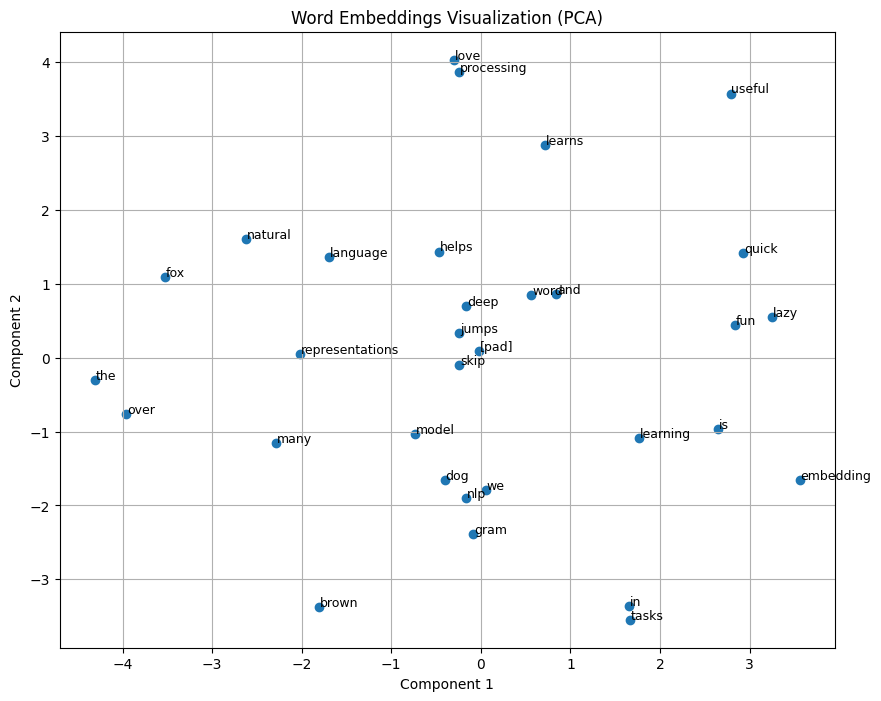

In [60]:
visualize_embeddings(skipgram_emb_layer, processor)

In [61]:
cbow_emb_layer = train(emb_model_cls=ContinuousBOW,
                  epochs=15,
                  batch_size=15,
                  learning_rate=0.01,
                  processor=cbow_processor,
                  pad_idx=0)

Epoch 1 | Loss: 3.6910270055135093
Epoch 2 | Loss: 3.2856690883636475
Epoch 3 | Loss: 3.1660770575205484
Epoch 4 | Loss: 2.9085769653320312
Epoch 5 | Loss: 2.5928186575571694
Epoch 6 | Loss: 2.538433313369751
Epoch 7 | Loss: 2.2117056051890054
Epoch 8 | Loss: 2.042897343635559
Epoch 9 | Loss: 1.9828063646952312
Epoch 10 | Loss: 1.8305630286534627
Epoch 11 | Loss: 1.578306754430135
Epoch 12 | Loss: 1.4171066681543987
Epoch 13 | Loss: 1.3170874913533528
Epoch 14 | Loss: 1.2115072806676228
Epoch 15 | Loss: 1.1454105774561565


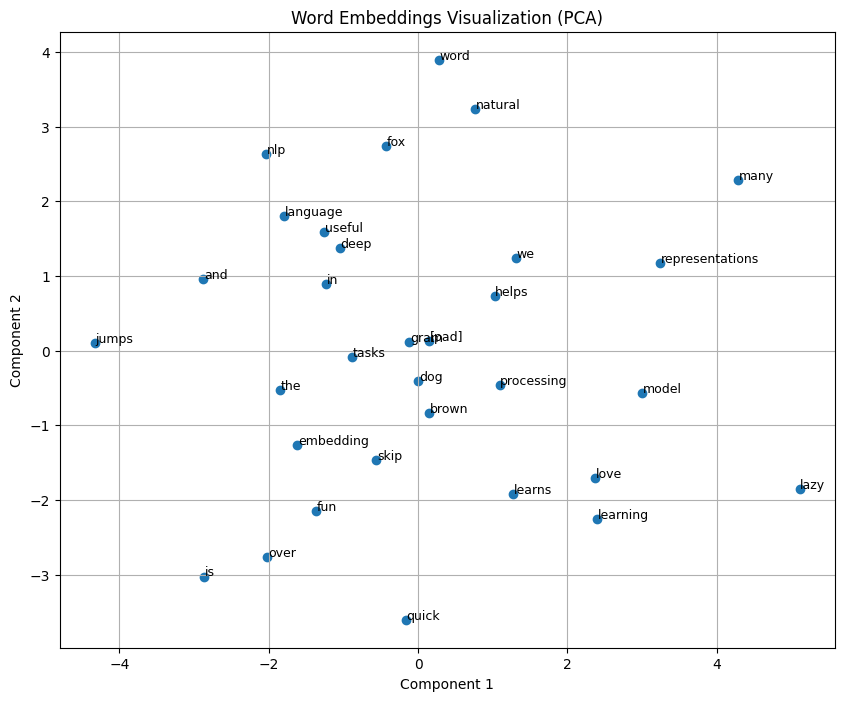

In [62]:
visualize_embeddings(cbow_emb_layer, cbow_processor)